In [38]:
#Import all the packages that I need
import spacy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In this Notebook I summarize everything that I did in the Sustainable Finance Hackaton.

The problem that I had to work was to nowcast and forecast the emission of CO2 of various industries in order to build a sustainable and green investment portfolio.
I had a large dataset, provided by RAM Active Investments (https://ram-ai.com/fr/), with data from ~ 10 thousands industries.
The main entries in the data are the emissions of  CO2 emissions (normalized by sales) at a time t_0 and t_1 and the 10-k reports, which are textual reports that the industries has to submit to the american government. 

I had to derive the change in the emissions of CO2 based on the textual report. I had to build algorithms with NLP (Natural Language Processing) and derive insights with Machine Learning.
It is a very difficult problem because the text report do not clearly say any evident informations about the emissions of CO2.  

# Explore the dataset

## Print the first entries of the dataset 

In [39]:
df = pd.read_json('10k_climate_risk_all.json')
df.head()

,cocik,coname,p_date,sector,RAM_GHGSALES_COMPOSITE_Y0,RAM_GHGSALES_COMPOSITE_Y1,filename,abstracts
0,66740,3M CO,2009-03-02,Producer Manufacturing,345.4337,274.6000,0001104659-09-009669,"[ The first was January through October, char..."
1,1111711,NISOURCE INC/DE,2009-03-02,Utilities,3418.0691,2720.5000,0000950152-09-001944,"[Whiting Clean Energy Whiting Clean Energy, In..."
2,1164727,NEWMONT MINING CORP /DE/,2009-03-02,Non-Energy Minerals,689.4680,859.1000,0000950134-09-003236,"[ In addition, production may be unexpectedly..."
3,789570,MGM MIRAGE,2009-03-02,Consumer Services,107.8141,107.9000,0000950153-09-000211,[Certain of our casino properties are located ...
4,1159297,MEADWESTVACO CORP,2009-03-02,Process Industries,393.2340,441.3516,0001193125-09-036284,[ Products include activated carbon used in e...


## An example of textual abstract from an industry. It can be seen that is very difficult extract useful information about CO2 emission

In [40]:
df['abstracts'][0]

['  The first was January through October, characterized by outstanding top-and bottom-line growth across most of the portfolio; the second chapter was the combined months of November and December, when many large customers slowed their operations. 3M expects that the strength of its new products, supply chain improvements and expansion into areas like energy, aerospace, filtration and now renewable energy, will help carry it through some very challenging times.']

## The different sectors of the industries

In [41]:
df['sector'].value_counts()

Finance                   1712
Producer Manufacturing     815
Electronic Technology      626
Process Industries         595
Utilities                  545
Consumer Non-Durables      534
Retail Trade               530
Industrial Services        445
Energy Minerals            439
Consumer Services          438
Transportation             339
Consumer Durables          299
Non-Energy Minerals        287
Health Technology          286
Technology Services        274
Distribution Services      212
Commercial Services        154
Health Services             73
Communications              60
Name: sector, dtype: int64

## I append different new columns in the dataset, which are the relative change of CO2 emissions, (y1 - y0)/y0. If it is positive I classifiy the industry as "increase" otherwise is "decrease", i.e. it increased or decreased the emissions of CO2

In [42]:
def f(y0,y1):
    return (y1-y0)/y0
df['RAM_GHG_RELATIVE_CHANGE']=df.apply(lambda x: f(x['RAM_GHGSALES_COMPOSITE_Y0'],x['RAM_GHGSALES_COMPOSITE_Y1']), axis=1)
df['Up_or_Down']=df['RAM_GHG_RELATIVE_CHANGE'].apply(lambda x: 'increase' if x >= 0 else 'decrease')
df['Abstracts_as_strings'] = df['abstracts'].str.join(". ")

## I check if there is any clear correlation in the numbers. For example, the larger is the current emission (y0) the larger is the relative change of emissions, i.e. the industries that pollutes more decrease more the emissions of CO2

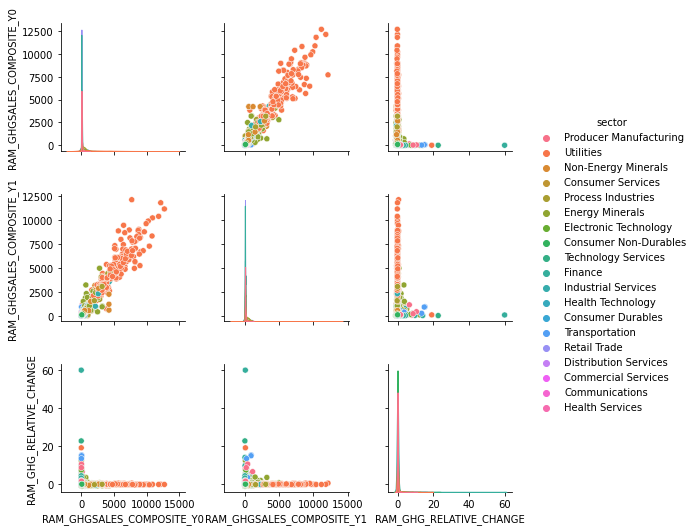

In [43]:
sns.pairplot(vars=["RAM_GHGSALES_COMPOSITE_Y0","RAM_GHGSALES_COMPOSITE_Y1","RAM_GHG_RELATIVE_CHANGE"], data=df, hue="sector")

# I run now some machine learning in order to predict wether an industry is going to increase or decrease the emission of CO2. I use Random Forest Classifieir

In [44]:
X = df['Abstracts_as_strings']
y = df['Up_or_Down']
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X)

0.6225761772853186


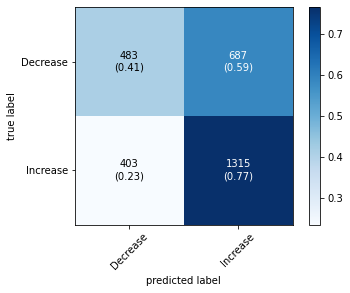

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.33, random_state=42)
regressor = RandomForestClassifier(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(accuracy_score(y_test,y_pred))

classes = ['Decrease', 'Increase']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

# Now I use unsupervised machine learning in order to extract topics about the abstract. I will the use the topics to re-do random forest classifier. I use Latent Dirichelt Allocation and Non-Negative Matrix Factorization

## Latent Dirichelt Allocation

In [46]:
cv = CountVectorizer(max_df = 0.95,min_df = 2,stop_words='english')
LDA = LatentDirichletAllocation(n_components = 7,random_state = 42)
dtm = cv.fit_transform(df['Abstracts_as_strings'])
LDA.fit(dtm)
for i,topic in enumerate(LDA.components_):
    print(f"The top 15 words in topic #{i}:")
    print([cv.get_feature_names()[index] for index in topic.argsort()[-15:]])
    print('\n')
    print('\n')

The top 15 words in topic #0:
['environmental', 'ghg', 'company', 'including', 'new', 'generation', 'epa', 'costs', 'gas', 'electric', 'renewable', 'emissions', 'power', 'nbsp', 'energy']




The top 15 words in topic #1:


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['markets', 'construction', 'systems', 'demand', 'customers', 'solar', 'products', 'business', 'including', 'services', 'power', 'projects', 'renewable', 'nbsp', 'energy']




The top 15 words in topic #2:
['impact', 'products', 'laws', 'including', 'gas', 'company', 'carbon', 'environmental', 'costs', 'operations', 'greenhouse', 'regulations', 'change', 'climate', 'emissions']




The top 15 words in topic #3:
['changes', 'insurance', 'hurricanes', 'results', 'impact', 'natural', 'adverse', 'operations', 'including', 'losses', 'business', 'events', 'conditions', 'weather', 'nbsp']




The top 15 words in topic #4:
['change', 'new', 'climate', 'costs', 'ghg', 'including', 'regulations', 'epa', 'greenhouse', 'oil', 'operations', 'natural', 'emissions', 'gas', 'nbsp']




The top 15 words in topic #5:
['loss', 'ended', 'cash', 'assets', 'costs', 'nbsp', 'related', 'tax', 'year', 'december', '31', 'income', 'energy', 'net', 'million']




The top 15 words in topic #6:
['ethanol', 'vehicle

In [47]:
topic_results_lda = LDA.transform(dtm)
lda_X_counts = np.concatenate((topic_results_lda,X_counts.toarray()),axis = 1)

0.6204986149584487


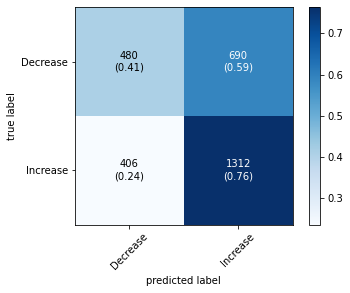

In [48]:
X_train, X_test, y_train, y_test = train_test_split(lda_X_counts, y, test_size=0.33, random_state=42)
regressor = RandomForestClassifier(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(accuracy_score(y_test,y_pred))

classes = ['Decrease', 'Increase']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

## Non negative Matrix Factorization

In [49]:
cv = CountVectorizer(max_df = 0.95,min_df = 2,stop_words='english')
nmf_model = NMF(n_components = 7, random_state = 42)
dtm = cv.fit_transform(df['Abstracts_as_strings'])
nmf_model.fit(dtm)
for i,topic in enumerate(nmf_model.components_):
    print(f"The top 15 words in topic #{i}:")
    print([cv.get_feature_names()[index] for index in topic.argsort()[-15:]])
    print('\n')
    print('\n')

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


The top 15 words in topic #0:
['regulations', 'demand', 'factors', 'costs', 'impact', 'business', 'operations', 'weather', 'conditions', 'ability', 'changes', 'natural', 'gas', 'including', 'nbsp']




The top 15 words in topic #1:


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['utilities', 'assets', 'december', 'million', 'wind', 'solar', 'electricity', 'facilities', 'clean', 'projects', 'generation', 'electric', 'power', 'renewable', 'energy']




The top 15 words in topic #2:
['act', 'generating', 'regulations', 'air', 'cost', 'epa', 'new', 'nbsp', 'emissions', 'costs', 'southern', 'environmental', 'including', 'power', 'company']




The top 15 words in topic #3:
['states', 'recovered', 'new', 'power', 'increase', 'note', 'rate', 'recovery', 'hurricane', 'damage', 'louisiana', 'storm', 'costs', 'million', 'entergy']




The top 15 words in topic #4:
['carbon', 'emission', 'costs', 'change', 'new', 'air', 'natural', 'climate', 'operations', 'regulations', 'greenhouse', 'epa', 'ghg', 'gas', 'emissions']




The top 15 words in topic #5:
['business', 'claim', 'weather', '31', 'expenses', 'loss', 'reinsurance', 'related', 'events', 'year', 'claims', 'net', 'catastrophe', 'losses', 'million']




The top 15 words in topic #6:
['income', 'cash', '31', 'incorpo

In [50]:
topic_results_nmf = nmf_model.transform(dtm)
nmf_X_counts = np.concatenate((topic_results_nmf,X_counts.toarray()),axis = 1)

0.6118421052631579


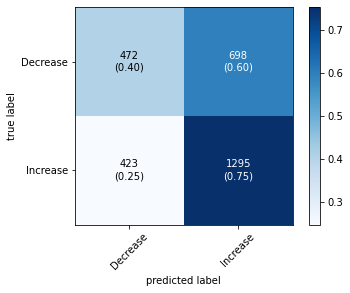

In [51]:
X_train, X_test, y_train, y_test = train_test_split(nmf_X_counts, y, test_size=0.33, random_state=42)
regressor = RandomForestClassifier(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(accuracy_score(y_test,y_pred))

classes = ['Decrease', 'Increase']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

## Combined

0.6225761772853186


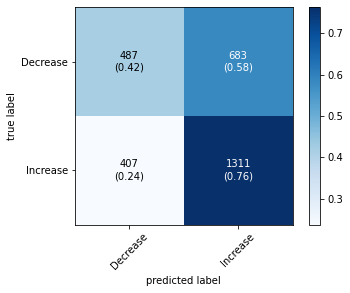

In [52]:
combined_X_counts = np.concatenate((topic_results_lda,topic_results_nmf,X_counts.toarray()),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(combined_X_counts, y, test_size=0.33, random_state=42)
regressor = RandomForestClassifier(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(accuracy_score(y_test,y_pred))

classes = ['Decrease', 'Increase']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

# Now I use pre-trained machine learning model, VADER, to extract sentiment. I put the sentiment analysis in the machine learning algorithm

In [53]:
sid = SentimentIntensityAnalyzer()
df['Vader_Output'] = df['Abstracts_as_strings'].apply(lambda review:sid.polarity_scores(review))
df['Vader_Array'] = df['Vader_Output'].apply(lambda vader: list(dict.values(vader)))
df.head()

,cocik,coname,p_date,sector,RAM_GHGSALES_COMPOSITE_Y0,RAM_GHGSALES_COMPOSITE_Y1,filename,abstracts,RAM_GHG_RELATIVE_CHANGE,Up_or_Down,Abstracts_as_strings,Vader_Output,Vader_Array
0,66740,3M CO,2009-03-02,Producer Manufacturing,345.4337,274.6000,0001104659-09-009669,"[ The first was January through October, char...",-0.205057,decrease,"The first was January through October, chara...","{'neg': 0.0, 'neu': 0.716, 'pos': 0.284, 'comp...","[0.0, 0.716, 0.284, 0.9657]"
1,1111711,NISOURCE INC/DE,2009-03-02,Utilities,3418.0691,2720.5000,0000950152-09-001944,"[Whiting Clean Energy Whiting Clean Energy, In...",-0.204083,decrease,"Whiting Clean Energy Whiting Clean Energy, Inc...","{'neg': 0.065, 'neu': 0.818, 'pos': 0.116, 'co...","[0.065, 0.818, 0.116, 0.9997]"
2,1164727,NEWMONT MINING CORP /DE/,2009-03-02,Non-Energy Minerals,689.4680,859.1000,0000950134-09-003236,"[ In addition, production may be unexpectedly...",0.246033,increase,"In addition, production may be unexpectedly ...","{'neg': 0.094, 'neu': 0.899, 'pos': 0.007, 'co...","[0.094, 0.899, 0.007, -0.9201]"
3,789570,MGM MIRAGE,2009-03-02,Consumer Services,107.8141,107.9000,0000950153-09-000211,[Certain of our casino properties are located ...,0.000797,increase,Certain of our casino properties are located i...,"{'neg': 0.116, 'neu': 0.813, 'pos': 0.071, 'co...","[0.116, 0.813, 0.071, -0.9918]"
4,1159297,MEADWESTVACO CORP,2009-03-02,Process Industries,393.2340,441.3516,0001193125-09-036284,[ Products include activated carbon used in e...,0.122364,increase,Products include activated carbon used in em...,"{'neg': 0.034, 'neu': 0.874, 'pos': 0.092, 'co...","[0.034, 0.874, 0.092, 0.9224]"


0.5706371191135734


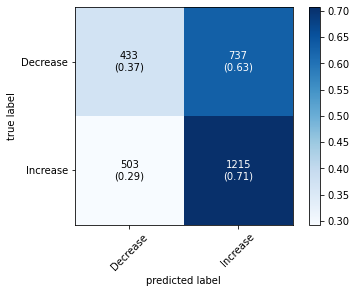

In [54]:
X = df['Vader_Array'].tolist()
y = df['Up_or_Down']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
regressor = RandomForestClassifier(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(accuracy_score(y_test,y_pred))

classes = ['Decrease', 'Increase']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

# Now I combine Vader with the combined vector used before. It has information from the topic extraction from LDA, NMF, Vader and the text vectorizer

0.6232686980609419


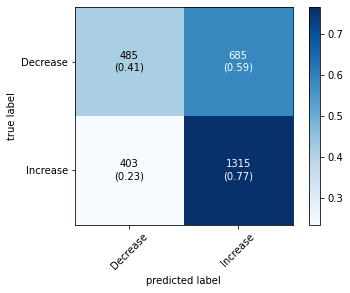

In [55]:
combined_X_counts_2 = np.concatenate((combined_X_counts,df['Vader_Array'].tolist()),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(combined_X_counts_2, y, test_size=0.33, random_state=42)
regressor = RandomForestClassifier(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(accuracy_score(y_test,y_pred))

classes = ['Decrease', 'Increase']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)

plt.show()